# [Computational Social Science] Project 4: Unsupervised Learning

Name: Neena Albarus 

Group Members: Sofia Guo, Stacy Chen, Marisa Tsai, Reiley Reed

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
!pip install keras

In [2]:
!pip install tensorflow

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

#ignore future warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [6]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


In [7]:
print(nhanes_scaled.HSD010)

SEQN
73568    1
73576    1
73579    2
73581    2
73584    3
        ..
83694    3
83696    2
83704    4
83716    1
83721    2
Name: HSD010, Length: 2064, dtype: int64


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

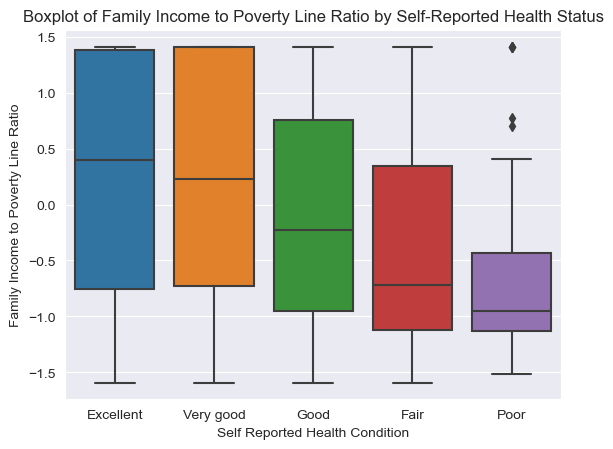

In [9]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['Excellent', 'Very good', 'Good', 'Fair', 'Poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

In [10]:
print(nhanes_scaled.HSD010)

SEQN
73568    Excellent
73576    Excellent
73579    Very good
73581    Very good
73584         Good
           ...    
83694         Good
83696    Very good
83704         Fair
83716    Excellent
83721    Very good
Name: HSD010, Length: 2064, dtype: object


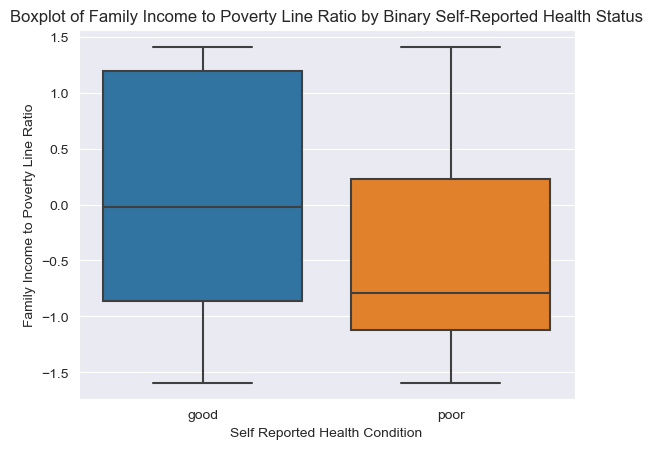

In [11]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

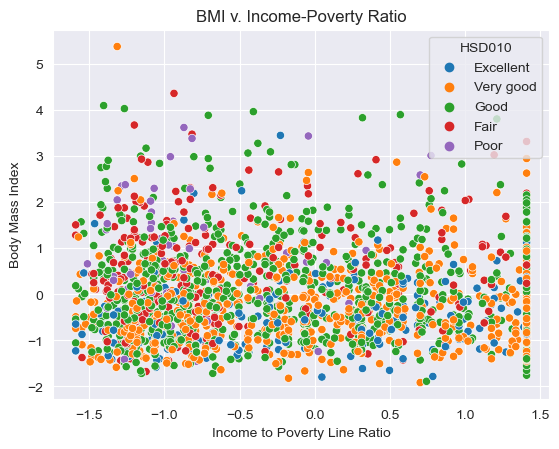

In [12]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [13]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

In [14]:
## Your Answer Here
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents_nhanes_scaled = pca.fit_transform(nhanes_scaled)

In [15]:
# convert into a dataframe
# ----------
pca_df = pd.DataFrame(data = principalComponents_nhanes_scaled
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])

In [16]:
# view factor loadings as dataframe
pca_df.head()

,principal component 1,principal component 2,principal component 3
0,9.527811,-0.816225,-1.867189
1,-5.838338,-3.692575,3.805757
2,-0.719454,-2.573202,0.907834
3,3.533628,-2.576984,-3.248927
4,-6.872094,-4.194241,0.886850


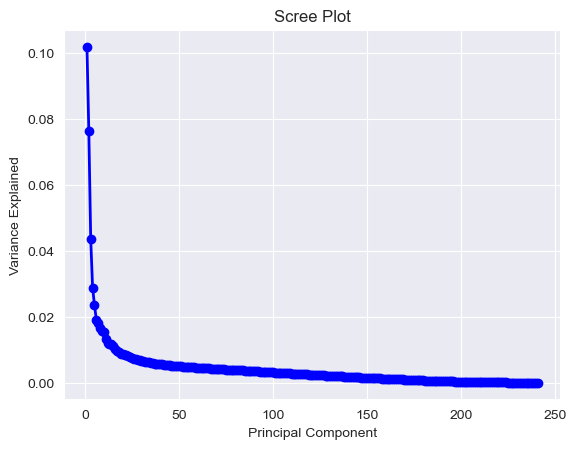

In [17]:
#assess how many components to keep using scree plot
#
# Create a Scree plot to evaluate the number of components to keep
# --------------------------------------------------

# fit PCA
# ----------
pca_all = PCA() # notice we do not specify the number of components if we want to keep them all
principalComponents_nhanes = pca_all.fit_transform(nhanes_scaled)


# create scree plot from PCA fit
# ----------
PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

### Barplot of Components

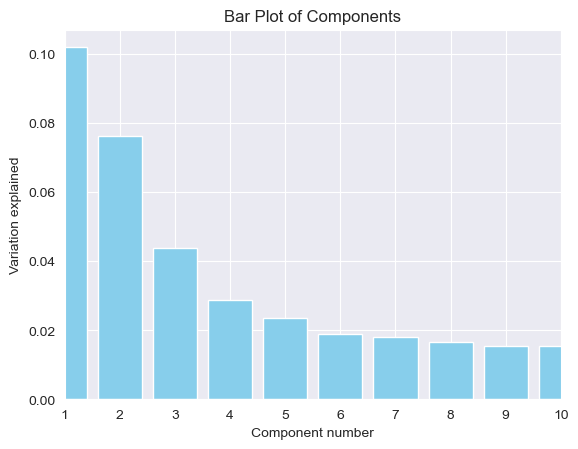

In [19]:
## Your Answer Here


# Plotting the bar plot
plt.bar(PC_values, pca_all.explained_variance_ratio_, color='skyblue')

# Adding labels and title
plt.xlabel('Component number')
plt.ylabel('Variation explained')
plt.title('Bar Plot of Components')

#include this piece to limit x-axis range to 1-10
plt.xlim(1, 10) 

# Display the plot
plt.show()

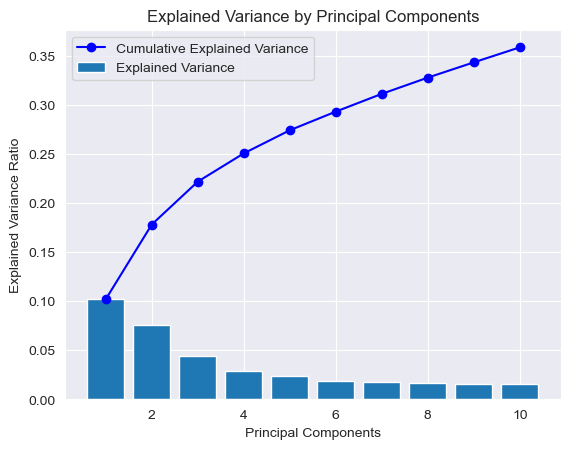

In [20]:
## Your Answer Here
pca = PCA(n_components=10)
principalComponents_nhanes_scaled = pca.fit_transform(nhanes_scaled)

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Barplot of the explained variance for each component
plt.bar(range(1, len(cumulative_explained_variance) + 1), pca.explained_variance_ratio_, label='Explained Variance')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, label='Cumulative Explained Variance', marker='o', color='blue')

plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.show()


### How many components will you use to fit a supervised learning model?

## Your Answer Here 

It seems reasonable to include 5 components since the explained variance ratio tends to stabilize after reaching 5, with each additional component showing diminishing returns after 5

### 2D Scatterplot of the first two components

In [21]:
## Your Answer Here

# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')

In [22]:
nhanes_scaled['HSD010'] 

SEQN
73568    1
73576    1
73579    2
73581    2
73584    3
        ..
83694    3
83696    2
83704    4
83716    1
83721    2
Name: HSD010, Length: 2064, dtype: int64

In [23]:
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010

In [24]:
#checking that appropriate variables are in the datasets
nhanes_scaled_columns = nhanes_scaled.columns
print("Column names of nhanes_scaled:", nhanes_scaled_columns)

pca_df_columns = pca_df.columns
print("Column names of pca_df:", pca_df_columns)

Column names of nhanes_scaled: Index(['DR1DRSTZ', 'DR1EXMER', 'DRABF', 'DRDINT', 'DR1DBIH', 'DR1DAY',
       'DR1LANG', 'DR1MNRSP', 'DR1HELPD', 'DBQ095Z',
       ...
       'OHQ845', 'PAAQUEX', 'SMQ860', 'SMQ870', 'SMQ872', 'SMQ874', 'SMQ878',
       'SMAQUEX.x', 'HSD010', 'SEQN'],
      dtype='object', length=243)
Column names of pca_df: Index(['principal component 1', 'principal component 2',
       'principal component 3'],
      dtype='object')


In [25]:
print(hsd010)

0       1
1       1
2       2
3       2
4       3
       ..
2059    3
2060    2
2061    4
2062    1
2063    2
Name: HSD010, Length: 2064, dtype: int64


In [26]:
hsd010 = hsd010.replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
print(hsd010)

0       excellent
1       excellent
2       very good
3       very good
4            good
          ...    
2059         good
2060    very good
2061         fair
2062    excellent
2063    very good
Name: HSD010, Length: 2064, dtype: object


<Figure size 640x480 with 0 Axes>

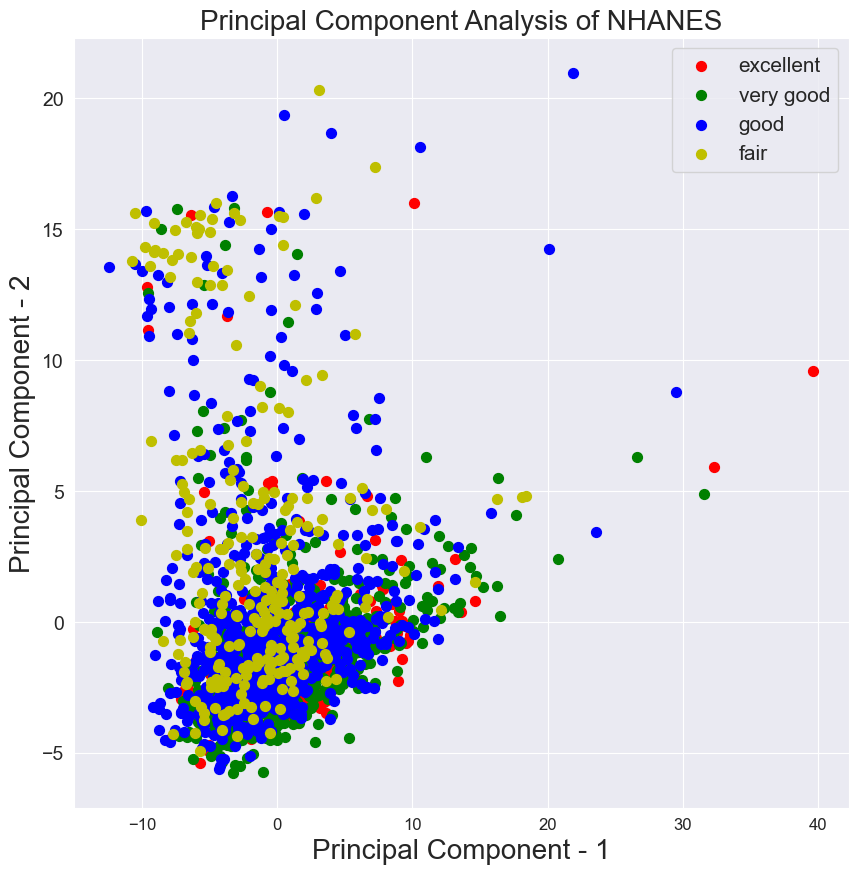

In [27]:
# plot
# ----------


# figure settings
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of NHANES",fontsize=20)
targets = ['excellent', 'very good', 'good', 'fair', 'poor']
colors = ['r', 'g', 'b', 'y']


# loop over targets and colors to create scatterplot
for target, color in zip(targets,colors):
    indicesToKeep = hsd010 == target
    indicesToKeep = indicesToKeep.reset_index(drop=True) #had to add this line
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

# show figure
plt.legend(targets,prop={'size': 15})
plt.show();



The different types of self reported health conditions appear evenly scattered. Including more components may be beneficial, as the distribution of self-reported health conditions in the plot indicates that the current two components do not explain variation effectively.

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

In [28]:
## Your Answer Here

# load libraries 
# ----------
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# settings
%matplotlib inline

In [29]:
# set random seed
np.random.seed(10)

In [30]:

# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
#nhanes_scaled.head()

In [31]:
X=nhanes_scaled

In [32]:
df = pd.DataFrame(X)

nhanes_scaled_columns = X.columns
print("Column names of nhanes_scaled:", nhanes_scaled_columns)

Column names of nhanes_scaled: Index(['DR1DRSTZ', 'DR1EXMER', 'DRABF', 'DRDINT', 'DR1DBIH', 'DR1DAY',
       'DR1LANG', 'DR1MNRSP', 'DR1HELPD', 'DBQ095Z',
       ...
       'OHQ770', 'OHQ845', 'PAAQUEX', 'SMQ860', 'SMQ870', 'SMQ872', 'SMQ874',
       'SMQ878', 'SMAQUEX.x', 'HSD010'],
      dtype='object', length=242)


In [33]:

# Keep only two variables (columns)
selected_columns = ["INDFMPIR", "BMXBMI"]
df_subset = df[selected_columns]

# Display the resulting DataFrame
print(df_subset)

X=df_subset

       INDFMPIR    BMXBMI
SEQN                     
73568  1.412214 -1.001972
73576 -0.642017 -0.618783
73579  0.192890 -1.636215
73581  1.412214 -0.565929
73584  0.252955 -0.341301
...         ...       ...
83694  0.343053 -0.341301
83696 -1.092507  0.081527
83704 -1.591048  1.508575
83716  0.589320 -0.499862
83721  1.412214 -0.301661

[2064 rows x 2 columns]


In [34]:
array_representation =X.values
array_representation

array([[ 1.41221429, -1.00197156],
       [-0.64201717, -0.61878288],
       [ 0.19288976, -1.63621489],
       ...,
       [-1.59104808,  1.50857496],
       [ 0.5893204 , -0.49986226],
       [ 1.41221429, -0.30166122]])

### Cluster nhanes

In [35]:
## Your Answer Here

# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=3,
                n_init=10,
                max_iter=300 #default
                ).fit(array_representation)


In [36]:

# print the centers 
print("Centers")
print(kmeans.cluster_centers_)
print()

# print labels
print("Labels")
print(kmeans.labels_)
print()

# print coordinates and labels 
for point, label in zip(array_representation, kmeans.labels_):
    print("Coordinates:", point, "Label:", label)
    

Centers
[[-0.35388349  1.47096992]
 [ 1.04255774 -0.31186857]
 [-0.82039429 -0.47090116]]

Labels
[1 2 2 ... 0 1 1]

Coordinates: [ 1.41221429 -1.00197156] Label: 1
Coordinates: [-0.64201717 -0.61878288] Label: 2
Coordinates: [ 0.19288976 -1.63621489] Label: 2
Coordinates: [ 1.41221429 -0.56592927] Label: 1
Coordinates: [ 0.25295501 -0.34130142] Label: 1
Coordinates: [-0.23357349  0.29294191] Label: 2
Coordinates: [0.40912465 1.42929454] Label: 0
Coordinates: [0.26496806 0.43828934] Label: 1
Coordinates: [1.41221429 1.37644093] Label: 1
Coordinates: [ 0.96172493 -0.89626434] Label: 1
Coordinates: [1.41221429 1.48214815] Label: 0
Coordinates: [-1.08650001 -0.07703337] Label: 2
Coordinates: [ 0.37308551 -0.2091674 ] Label: 1
Coordinates: [-1.30874142  0.05510066] Label: 2
Coordinates: [0.54727472 0.34579552] Label: 1
Coordinates: [-0.720102    0.31936871] Label: 2
Coordinates: [-0.22756697  1.31037392] Label: 0
Coordinates: [1.41221429 0.17402128] Label: 1
Coordinates: [-0.51588016  0.43

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

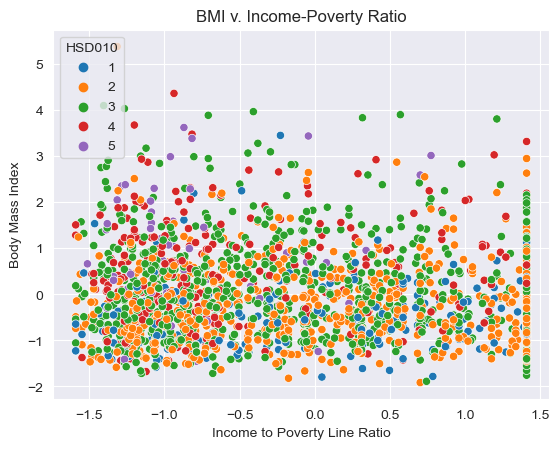

In [37]:
## Your Answer Here

# without clusters

ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

No clear pattern is observed in perceived health relative to BMI and income to the poverty line. However, fewer excellent ratings may be associated with higher BMI values.

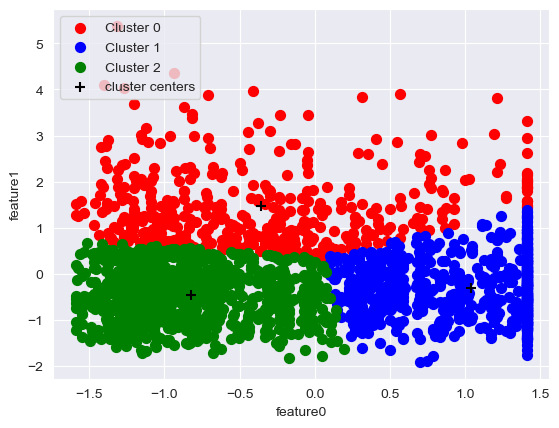

In [38]:
# with clusters
# figure settings
fig = plt.figure()
ax1 = fig.add_subplot(111)

# plot
ax1.scatter(*array_representation[kmeans.labels_==0,:].T, s=50, c='r', label='Cluster 0')
ax1.scatter(*array_representation[kmeans.labels_==1,:].T, s=50, c='b', label='Cluster 1')
ax1.scatter(*array_representation[kmeans.labels_==2,:].T, s=50, c='g', label='Cluster 2')
ax1.scatter(*kmeans.cluster_centers_.T, s=50, marker='+', c='black', label='cluster centers')
plt.legend(loc='upper left')
plt.xlabel('feature0')
plt.ylabel('feature1')
plt.show()

## Your Answer Here  

Unlike prior plots, it appears that the cluster assignments are well described by the PCA-reduced features, given the clear pattern above.

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [39]:
## Your Answer Here

# specify kmeans algorithm
# ----------
kmeans = KMeans(n_clusters=3,
                n_init=10,
                max_iter=300 #default
                ).fit(pca_df)

In [40]:

# print the centers 
print("Centres")
print(kmeans.cluster_centers_)
print()

# print labels
print("Labels")
print(kmeans.labels_)
print()

# print coordinates and labels 
for point, label in zip(pca_df, kmeans.labels_):
    print("Coordinates:", point, "Label:", label)
    

Centres
[[-1.93810871 -1.66469649  0.1412452 ]
 [ 5.94835981  0.30929533  0.13266669]
 [-4.09075955 10.88608907 -1.40038539]]

Labels
[1 0 0 ... 0 1 0]

Coordinates: principal component 1 Label: 1
Coordinates: principal component 2 Label: 0
Coordinates: principal component 3 Label: 0


## Your Answer Here

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [41]:
# load libraries
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
#from keras.layers.convolutional import Conv2D
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
#from keras.utils import np_utils
from keras import backend as K
K.set_image_data_format('channels_last')
#K.set_image_dim_ordering('th')
from keras.datasets import mnist

In [43]:
#checking what variables are in the dataset

nhanes_scaled_columns = nhanes_scaled.columns
print("Column names of nhanes_scaled:", nhanes_scaled_columns)

Column names of nhanes_scaled: Index(['DR1DRSTZ', 'DR1EXMER', 'DRABF', 'DRDINT', 'DR1DBIH', 'DR1DAY',
       'DR1LANG', 'DR1MNRSP', 'DR1HELPD', 'DBQ095Z',
       ...
       'OHQ770', 'OHQ845', 'PAAQUEX', 'SMQ860', 'SMQ870', 'SMQ872', 'SMQ874',
       'SMQ878', 'SMAQUEX.x', 'HSD010'],
      dtype='object', length=242)


In [44]:
y = hsd010 # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 

In [45]:
# drop out any columns that aren't features
nhanes_scaled =nhanes_scaled.drop(['HSD010'], axis = 1) 
#SEQN already dropped

In [46]:
X=nhanes_scaled

In [47]:
y.shape

(2064,)

In [48]:
y

0       1
1       1
2       2
3       2
4       3
       ..
2059    3
2060    2
2061    4
2062    1
2063    2
Name: HSD010, Length: 2064, dtype: int64

In [49]:
#y = ... # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
#X = ... # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [50]:
y_train.shape

(1548,)

In [51]:
y_train

604     1
1907    2
1487    4
899     1
494     3
       ..
2009    2
1180    3
1344    2
527     3
1289    4
Name: HSD010, Length: 1548, dtype: int64

In [52]:
y_test

85      2
1762    3
1002    2
1339    1
1699    3
       ..
2026    2
803     3
1377    2
550     2
126     2
Name: HSD010, Length: 516, dtype: int64

In [53]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 
                                     num_classes)
y_test = keras.utils.to_categorical(y_test, 
                                    num_classes)
num_classes = y_test.shape[1]

In [54]:
# create neural network model
# -----------
model = Sequential()
#y train = categories in outcome variable
#x train = # of features in data
model.add(Dense(y_train.shape[1], input_dim= X_train.shape[1], kernel_initializer= 'normal', activation= 'relu'))

model.add(Dense(num_classes, kernel_initializer= 'normal', activation= 'softmax'))

In [55]:
## Add any additional layers you wish here


model.compile(loss='categorical_crossentropy',   # specify the loss function
              optimizer='adam',                  # specify optimizer - Adam is an adaptive learning rate optimization algorithm.
              metrics=['accuracy'])              # specify metrics

#fit to training data
# this line is what needs to be changed for the next two questions
#model.fit(..., ..., validation_data=(..., ...), epochs=..., batch_size=..., verbose=2)

model.fit(X_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(X_test,  # specify the validation data
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2);               # print as it goes (similar to folds 

Epoch 1/10
8/8 - 1s - loss: 2.2881 - accuracy: 0.1208 - val_loss: 2.2628 - val_accuracy: 0.1822 - 664ms/epoch - 83ms/step
Epoch 2/10
8/8 - 0s - loss: 2.2323 - accuracy: 0.2306 - val_loss: 2.2087 - val_accuracy: 0.2578 - 32ms/epoch - 4ms/step
Epoch 3/10
8/8 - 0s - loss: 2.1686 - accuracy: 0.3094 - val_loss: 2.1416 - val_accuracy: 0.3314 - 64ms/epoch - 8ms/step
Epoch 4/10
8/8 - 0s - loss: 2.0902 - accuracy: 0.3488 - val_loss: 2.0629 - val_accuracy: 0.3605 - 32ms/epoch - 4ms/step
Epoch 5/10
8/8 - 0s - loss: 2.0018 - accuracy: 0.3740 - val_loss: 1.9751 - val_accuracy: 0.3779 - 60ms/epoch - 8ms/step
Epoch 6/10
8/8 - 0s - loss: 1.9058 - accuracy: 0.4025 - val_loss: 1.8816 - val_accuracy: 0.3837 - 32ms/epoch - 4ms/step
Epoch 7/10
8/8 - 0s - loss: 1.8063 - accuracy: 0.4360 - val_loss: 1.7851 - val_accuracy: 0.4225 - 31ms/epoch - 4ms/step
Epoch 8/10
8/8 - 0s - loss: 1.7058 - accuracy: 0.4503 - val_loss: 1.6913 - val_accuracy: 0.4360 - 47ms/epoch - 6ms/step
Epoch 9/10
8/8 - 0s - loss: 1.6130 - a

In [56]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (1548, 241)
y_train shape: (1548, 10)


### Neural Network on Principal Components

In [57]:
y = hsd010 # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
#nhanes_scaled_pca =pca_df.drop(['HSD010'], axis = 1) # drop out any columns that aren't features
#SEQN already dropped


In [58]:
y.shape

(2064,)

In [59]:
X=pca_df

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [61]:
y_train.shape

(1548,)

In [62]:
y

0       1
1       1
2       2
3       2
4       3
       ..
2059    3
2060    2
2061    4
2062    1
2063    2
Name: HSD010, Length: 2064, dtype: int64

In [63]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 
                                     num_classes)
y_test = keras.utils.to_categorical(y_test, 
                                    num_classes)
num_classes = y_test.shape[1]

In [64]:
# create neural network model
# -----------
model = Sequential()

#y_train [1]= categories in outcome variable
#x_train[1] = # of features in data
model.add(Dense(y_train.shape[1], input_dim= X_train.shape[1], kernel_initializer= 'normal', activation= 'relu'))

model.add(Dense(y_train.shape[1], kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here


model.compile(loss='categorical_crossentropy',   # specify the loss function
              optimizer='adam',                  # specify optimizer - Adam is an adaptive learning rate optimization algorithm.
              metrics=['accuracy'])              # specify metrics

#fit to training data
# this line is what needs to be changed for the next two questions
#model.fit(..., ..., validation_data=(..., ...), epochs=..., batch_size=..., verbose=2)

model.fit(X_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(X_test,  # specify the validation data
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross validation)



Epoch 1/10
8/8 - 0s - loss: 2.2955 - accuracy: 0.1925 - val_loss: 2.2827 - val_accuracy: 0.2965 - 452ms/epoch - 57ms/step
Epoch 2/10
8/8 - 0s - loss: 2.2731 - accuracy: 0.3140 - val_loss: 2.2602 - val_accuracy: 0.3547 - 47ms/epoch - 6ms/step
Epoch 3/10
8/8 - 0s - loss: 2.2491 - accuracy: 0.3508 - val_loss: 2.2348 - val_accuracy: 0.3643 - 43ms/epoch - 5ms/step
Epoch 4/10
8/8 - 0s - loss: 2.2213 - accuracy: 0.3559 - val_loss: 2.2056 - val_accuracy: 0.3779 - 35ms/epoch - 4ms/step
Epoch 5/10
8/8 - 0s - loss: 2.1896 - accuracy: 0.3643 - val_loss: 2.1716 - val_accuracy: 0.3740 - 47ms/epoch - 6ms/step
Epoch 6/10
8/8 - 0s - loss: 2.1529 - accuracy: 0.3714 - val_loss: 2.1329 - val_accuracy: 0.3721 - 32ms/epoch - 4ms/step
Epoch 7/10
8/8 - 0s - loss: 2.1117 - accuracy: 0.3786 - val_loss: 2.0897 - val_accuracy: 0.3857 - 31ms/epoch - 4ms/step
Epoch 8/10
8/8 - 0s - loss: 2.0665 - accuracy: 0.3876 - val_loss: 2.0430 - val_accuracy: 0.3934 - 48ms/epoch - 6ms/step
Epoch 9/10
8/8 - 0s - loss: 2.0181 - a

In [65]:
y_train.shape

(1548, 10)

### Neural Network on Principal Components + Cluster Membership

In [70]:
y = hsd010 # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already 
#nhanes_scaled_pca =pca_df.drop(['HSD010'], axis = 1) # drop out any columns that aren't features
#SEQN already dropped

In [ ]:
X=array_representation

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [72]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, 
                                     num_classes)
y_test = keras.utils.to_categorical(y_test, 
                                    num_classes)
num_classes = y_test.shape[1]

In [73]:
# create neural network model
# -----------
model = Sequential()

#y_train [1]= categories in outcome variable
#x_train[1] = # of features in data
model.add(Dense(y_train.shape[1], input_dim= X_train.shape[1], kernel_initializer= 'normal', activation= 'relu'))

model.add(Dense(y_train.shape[1], kernel_initializer= 'normal', activation= 'softmax'))

## Add any additional layers you wish here


model.compile(loss='categorical_crossentropy',   # specify the loss function
              optimizer='adam',                  # specify optimizer - Adam is an adaptive learning rate optimization algorithm.
              metrics=['accuracy'])              # specify metrics

#fit to training data
# this line is what needs to be changed for the next two questions
#model.fit(..., ..., validation_data=(..., ...), epochs=..., batch_size=..., verbose=2)

model.fit(X_train,                  # specify the x data
          y_train,                  # specify the y data
          validation_data=(X_test,  # specify the validation data
                           y_test), 
          epochs=10,                # number of iterations back and forth through the network
          batch_size=200,           # number of images it will input per batch 
          verbose=2);               # print as it goes (similar to folds in cross validation)



Epoch 1/10
8/8 - 0s - loss: 2.3093 - accuracy: 0.1621 - val_loss: 2.2956 - val_accuracy: 0.1919 - 471ms/epoch - 59ms/step
Epoch 2/10
8/8 - 0s - loss: 2.2861 - accuracy: 0.2287 - val_loss: 2.2743 - val_accuracy: 0.2616 - 32ms/epoch - 4ms/step
Epoch 3/10
8/8 - 0s - loss: 2.2638 - accuracy: 0.2868 - val_loss: 2.2524 - val_accuracy: 0.3101 - 31ms/epoch - 4ms/step
Epoch 4/10
8/8 - 0s - loss: 2.2403 - accuracy: 0.3120 - val_loss: 2.2279 - val_accuracy: 0.3256 - 31ms/epoch - 4ms/step
Epoch 5/10
8/8 - 0s - loss: 2.2134 - accuracy: 0.3359 - val_loss: 2.1997 - val_accuracy: 0.3605 - 25ms/epoch - 3ms/step
Epoch 6/10
8/8 - 0s - loss: 2.1820 - accuracy: 0.3475 - val_loss: 2.1664 - val_accuracy: 0.3605 - 31ms/epoch - 4ms/step
Epoch 7/10
8/8 - 0s - loss: 2.1455 - accuracy: 0.3527 - val_loss: 2.1279 - val_accuracy: 0.3585 - 33ms/epoch - 4ms/step
Epoch 8/10
8/8 - 0s - loss: 2.1033 - accuracy: 0.3592 - val_loss: 2.0843 - val_accuracy: 0.3566 - 47ms/epoch - 6ms/step
Epoch 9/10
8/8 - 0s - loss: 2.0563 - a

Epoch 1/10
8/8 - 0s - loss: 1.9513 - accuracy: 0.3637 - val_loss: 1.9314 - val_accuracy: 0.3527 - 63ms/epoch - 8ms/step
Epoch 2/10
8/8 - 0s - loss: 1.8961 - accuracy: 0.3656 - val_loss: 1.8768 - val_accuracy: 0.3527 - 33ms/epoch - 4ms/step
Epoch 3/10
8/8 - 0s - loss: 1.8400 - accuracy: 0.3663 - val_loss: 1.8230 - val_accuracy: 0.3566 - 46ms/epoch - 6ms/step
Epoch 4/10
8/8 - 0s - loss: 1.7857 - accuracy: 0.3708 - val_loss: 1.7705 - val_accuracy: 0.3643 - 31ms/epoch - 4ms/step
Epoch 5/10
8/8 - 0s - loss: 1.7336 - accuracy: 0.3773 - val_loss: 1.7200 - val_accuracy: 0.3798 - 47ms/epoch - 6ms/step
Epoch 6/10
8/8 - 0s - loss: 1.6838 - accuracy: 0.3921 - val_loss: 1.6729 - val_accuracy: 0.3740 - 47ms/epoch - 6ms/step
Epoch 7/10
8/8 - 0s - loss: 1.6385 - accuracy: 0.4083 - val_loss: 1.6295 - val_accuracy: 0.3857 - 47ms/epoch - 6ms/step
Epoch 8/10
8/8 - 0s - loss: 1.5966 - accuracy: 0.4147 - val_loss: 1.5910 - val_accuracy: 0.3876 - 48ms/epoch - 6ms/step
Epoch 9/10
8/8 - 0s - loss: 1.5603 - acc

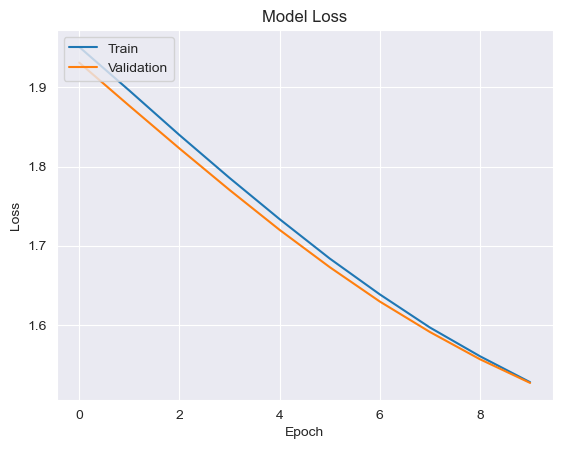

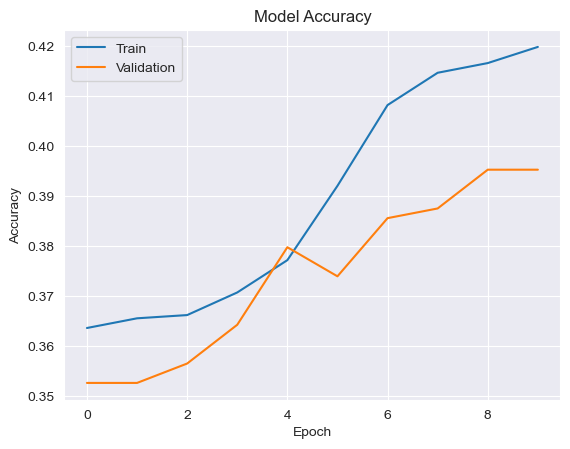

In [74]:
import matplotlib.pyplot as plt

# history is the output of  model.fit() function
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA reduces the shape dimensionality by transforming original features in the dataset into uncorrelated components. Clustering groups similar observations based on similarity in the feature space.

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

One potential benefit is improved interpretability and clustering performance. Lack of advantages might stem from irrelevant PCA-captured features. In my observation, using PCA and clustering proved beneficial. Without PCA, interpreting patterns in reported health status was challenging. However, with PCA-reduced features and clustered outcomes, a clearer relationship emerged.


## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques can help to identify patterns and relationships in vast datasets that do not have predefined labels. They also assist in feature reduction and grouping which provides insights for downstream supervised learning